### Libraries

In [47]:
from openai import OpenAI, RateLimitError, APIError, APITimeoutError, AuthenticationError, BadRequestError, NotFoundError
from google.api_core.exceptions import ResourceExhausted, RetryError, DeadlineExceeded
import google.generativeai as genai
import tiktoken

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# from multiprocessing import Pool
import time
import os
import ast

### Layout

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_seq_items', None)

### Data

In [3]:
literature = np.load('literature.npy', allow_pickle=True).item()
example = np.load('example.npy', allow_pickle=True).item()

### General commands for getting response

In [39]:
text = "{{'Qualitative method': '1', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '0', 'Households': '1', 'Subnational groups': '1', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '0', \
'Rainfall pattern / Variability': '1', 'Temperature change': '0', 'Food scarcity / Famine / Food security': '1', 'Drought / Aridity / Desertification': '1', \
'Floods': '1', 'Erosion / Soil fertilty / Land degradation / Deforestation / Salinisation': '1', 'Self assessement / Perceived environment': '1', \
'Labour migration': '1', 'Marriage migration': '0', 'Refugees': '0', 'International migration': '0', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '1', 'Circular / Seasonal': '1', 'Long distance': '1', 'Short distance': '0', 'Temporal': '1', 'Permanent': '0', \
'Age': '1', 'Gender': '0', 'Ethnicity / Religion': '0'}}"
enc = tiktoken.encoding_for_model("gpt-4.1-mini")
MAX_TOKEN = len(enc.encode(text))

In [5]:
def api_def(provider):
    # API keys are hidden in another file
    with open('api.txt', 'r', encoding='utf-8') as file:
        lines = [line.strip() for line in file.readlines()]

        # Different LLMs need different kinds of command
        if provider == 'chatgpt':
            client = OpenAI(api_key=str(lines[0]), base_url="https://api.openai.com/v1")
            return client
        
        elif provider == 'deepseek':
            client = OpenAI(api_key=str(lines[1]), base_url="https://api.deepseek.com")
            return client
        
        elif provider == 'gemini':
            genai.configure(api_key=str(lines[2]))

In [6]:
def get_completion(prompt, provider, model, temperature):
    messages = [{"role": "system", "content": "You are a research assistant conducting a systematic literature review on climate mobility. \
    Your task is to read the provided text and classify it according to the given properties with binary codes. \
    Do not include explanations, personal opinions or provide unrelated meta-comments in the answer. Provide only the classification results."},
               {"role": "user", "content": prompt}]

    # Different LLMs need different kinds of command
    if provider == 'gpt':
        client = api_def('chatgpt')
        response = client.responses.create(
            model=model,
            input=messages,
            temperature=temperature,
            max_output_tokens = round(MAX_TOKEN + 3)
        )
        return response.output_text
        
    elif provider == 'ds':
        client = api_def('deepseek')
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens = round(MAX_TOKEN * 1.2)
        )
        return response.choices[0].message.content

    elif provider == 'gemini':
        api_def('gemini')
        model_gemini = genai.GenerativeModel(model)
        response = model_gemini.generate_content(
            prompt,
            generation_config={"temperature": temperature, "max_output_tokens": round(MAX_TOKEN * 1.3)}
        )
        return response.text        

### Prompt and response processing

In [8]:
CONTEXT = f"""
We are conducting a systematic review of climate mobility literature. For each paper, your task is to assign some binary codes, namely '0' or '1', \
for the specific indicators that I will provide, to categorize the paper across multiple dimensions for later analysis. \n

While reviewing a paper, evaluate *only the content of this paper*. Do not use information from any other paper. Do not infer missing information from \
past tasks or earlier papers. Focus primarily on the abstract, data/methods, results, and conclusions sections. \
Do not rely on introduction, state-of-the-art, related works, or motivation sections, especially when they describe other researchers’ work. \
Only use information from those sections if they explicitly describe what *this paper* does. \n

For each index, output one and only one character: '0' (for 'No') or '1' (Yes), according to the concrete explanation below. Do not provide explanations. \
Each indicator is independent, do not infer one indicator based on another. Please follow strictly the format I will specify later. \
When information is missing or unclear, just assign '0'.
"""

In [11]:
ZERO_SHOT_PROMPT_1 = f"""

<Prof>: 
{CONTEXT} \n

The following 13 indicators will be used to categorize each paper, regarding its general information: \n
a. Methods used for data analysis (refers only to analytical methods, not methods for data collection) (2 indicators): 1. 'Qualitative method' and \
2. 'Quantitative method'. Note that a paper may use both, one, or neither. \n
b. Types of data included for analysis (2 indicators): 3. 'Socio-demo-economic data' ('demo' means 'demographic') and 4. 'Environmental data'. Please \
only assign '1' when a type of data is used (no matter how data is collected), while only mentioning an aspect of this paper doesn't count. \
Note that a paper can include both, one, or neither. \n
c. Focal demographic units of analysis (refers to the units of analysis, not research areas) (5 indicators): 5. 'Individuals', 6. 'Households', \
7. 'Subnational groups' (like community, province, etc.), 8. 'National groups', 9. 'International groups'. Note that a paper can focus on several, \
one or none of them. \n
d. Research location types (refers to the places where research took place, not where people move to) (2 indicators): 10. 'Urban', 11. 'Rural'. \
A study may focus on both, one, or neither. \n
e. Temporal aspects (2 indicators): 12. 'Time frame considered' (e.g., temporal analysis was used), 13. 'Foresight' (e.g., forecast, prediction, and \
future perspectives was/were addressed). A paper may consider both, one, or neither of them. \n \n


Always output the result in the following Python Dictionary structure with identical order, with each blank replaced by 0 or 1 only, and no extra text: \n
{{'Qualitative method': '_', 'Quantitative method': '_', 'Socio-demo-economic data': '_', 'Environmental data': '_', \
'Individuals': '_', 'Households': '_', 'Subnational groups': '_', 'National groups': '_', 'International groups': '_', \
'Urban': '_', 'Rural': '_', 'Time frame considered': '_', 'Foresight': '_'}}
"""

In [40]:
ZERO_SHOT_PROMPT_2 = f"""

<Prof>: 
{CONTEXT} \n

The following 7 indicators will be used to categorize each paper, regarding environmental stressors being considered for analysis in the study: \n
1. 'Rainfall pattern / Variability', 2. 'Temperature change', 3. 'Food scarcity / Famine / Food security', \
4. 'Drought / Aridity / Desertification', 5. 'Floods', 6. 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation', \
7. 'Self assessement / Perceived environment '. \n
Only assign '1' when a stressor is explicitly used for analysis, while only mentioning without evidence doesn't count. \
Note that indicator 7 indicates that the above stressors measured via human perception were included in the paper, \
no matter if data from observation was also included. For indicators 1 to 6, a paper may include multiple, one, or none. \n 

Always output the result in the following Python Dictionary structure with identical order, with each blank replaced by 0 or 1 only, and no extra text: \n
{{'Rainfall pattern / Variability': '_', 'Temperature change': '_', 'Food scarcity / Famine / Food security': '_', 'Drought / Aridity / Desertification': '_', \
'Floods': '_', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '_', 'Self assessement / Perceived environment': '_'}}
"""

In [15]:
ZERO_SHOT_PROMPT_3 = f"""

<Prof>: 
{CONTEXT} \n

The following 8 indicators will be used to categorize each paper, regarding migration types being discussed in the study: \n
1. 'Labour migration' (migration related to work), 2. 'Marriage migration', 3. 'Refugees', \
4. 'International migration', 5. 'Cross-border migration' (compared to 'International migration' which indicates those migration with longer \
distance, 'Cross-border migration' denotes those migration that people move only from one nation to an adjacent one), 6. 'Internal migration' (those \
migration within one single nation), 7. 'Rural to urban', 8. 'Rural to rural'. Note that a paper might contain multiple, one, or none of them. \n

Always output the result in the following Python Dictionary structure with identical order, with each blank replaced by 0 or 1 only, and no extra text: \n
{{'Labour migration': '_', 'Marriage migration': '_', 'Refugees': '_', 'International migration': '_', 'Cross-border migration': '_', 'Internal migration': '_', \
'Rural to urban': '_', 'Rural to rural': '_'}}
"""

In [16]:
ZERO_SHOT_PROMPT_4 = f"""

<Prof>: 
{CONTEXT} \n

The following 5 indicators will be used to categorize each paper, regarding migration patterns being discussed in the study: \n
1. 'Circular / Seasonal', 2. 'Long distance', 3. 'Short distance', 4. 'Temporal' \
(migrants may come back), and 5. 'Permanent' (migrants will not come back). Note that a paper can also consider multiple, one, or none of them. \n

Always output the result in the following Python Dictionary structure with identical order, with each blank replaced by 0 or 1 only, and no extra text: \n
{{'Circular / Seasonal': '_', 'Long distance': '_', 'Short distance': '_', 'Temporal': '_', 'Permanent': '_'}}
"""

In [17]:
ZERO_SHOT_PROMPT_5 = f"""

<Prof>: 
{CONTEXT} \n

The following 3 indicators will be used to categorize each paper, indicating if specific demographic characteristics are used as variables \
(only mentioning without serving as variables doesn't count): 1. 'Age', 2. 'Gender', 3. 'Ethnicity / Religion'. \
Note that a paper can also consider multiple, one, or none of them. \n

Always output the result in the following Python Dictionary structure with identical order, with each blank replaced by 0 or 1 only, and no extra text: \n
{{'Age': '_', 'Gender': '_', 'Ethnicity / Religion': '_'}}
"""

In [18]:
THREE_SHOT_PROMPT_1 = f"""

{ZERO_SHOT_PROMPT_1} \n

Now please try to code the following 3 papers: \n
\"\"\"{example}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Qualitative method': '1', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '0', 'Households': '1', 'Subnational groups': '1', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '0'}}, \
{{'Qualitative method': '0', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '0', 'Households': '1', 'Subnational groups': '0', 'National groups': '0', 'International groups': '0', \
'Urban': '1', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '1'}}, \
{{'Qualitative method': '0', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '1', 'Households': '1', 'Subnational groups': '0', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '0'}}
"""

In [41]:
THREE_SHOT_PROMPT_2 = f"""

{ZERO_SHOT_PROMPT_2} \n

Now please try to code the following 3 papers: \n
\"\"\"{example}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Rainfall pattern / Variability': '1', 'Temperature change': '0', 'Food scarcity / Famine / Food security': '1', 'Drought / Aridity / Desertification': '1', \
'Floods': '1', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '1', 'Self assessement / Perceived environment': '1'}}, \
{{'Rainfall pattern / Variability': '1', 'Temperature change': '1', 'Food scarcity / Famine / Food security': '0', 'Drought / Aridity / Desertification': '0', \
'Floods': '0', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '0', 'Self assessement / Perceived environment': '0'}}, \
{{'Rainfall pattern / Variability': '0', 'Temperature change': '0', 'Food scarcity / Famine / Food security': '0', 'Drought / Aridity / Desertification': '0', \
'Floods': '0', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '1', 'Self assessement / Perceived environment': '0'}}
"""

In [20]:
THREE_SHOT_PROMPT_3 = f"""

{ZERO_SHOT_PROMPT_3} \n

Now please try to code the following 3 papers: \n
\"\"\"{example}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Labour migration': '1', 'Marriage migration': '0', 'Refugees': '0', 'International migration': '0', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '1'}}, \
{{'Labour migration': '1', 'Marriage migration': '0', 'Refugees': '0', 'International migration': '1', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '0'}}, \
{{'Labour migration': '1', 'Marriage migration': '1', 'Refugees': '0', 'International migration': '0', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '0'}}
"""

In [21]:
THREE_SHOT_PROMPT_4 = f"""

{ZERO_SHOT_PROMPT_4} \n

Now please try to code the following 3 papers: \n
\"\"\"{example}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Circular / Seasonal': '1', 'Long distance': '1', 'Short distance': '0', 'Temporal': '1', 'Permanent': '0'}}, \
{{'Circular / Seasonal': '1', 'Long distance': '1', 'Short distance': '1', 'Temporal': '1', 'Permanent': '1'}}, \
{{'Circular / Seasonal': '1', 'Long distance': '0', 'Short distance': '1', 'Temporal': '1', 'Permanent': '1'}}
"""

In [22]:
THREE_SHOT_PROMPT_5 = f"""

{ZERO_SHOT_PROMPT_5} \n

Now please try to code the following 3 papers: \n
\"\"\"{example}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Age': '1', 'Gender': '0', 'Ethnicity / Religion': '0'}}, \
{{'Age': '0', 'Gender': '0', 'Ethnicity / Religion': '0'}}, \
{{'Age': '1', 'Gender': '1', 'Ethnicity / Religion': '0'}}
"""

In [23]:
THREE_SHOT_SEPARATE_PROMPT_1 = f"""

{ZERO_SHOT_PROMPT_1} \n

Now please try to code the following paper: \n
\"\"\"{example[0]}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Qualitative method': '1', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '0', 'Households': '1', 'Subnational groups': '1', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '0'}}, \n
<Prof>: Please try to code another paper below: \n
\"\"\"{example[1]}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Qualitative method': '0', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '0', 'Households': '1', 'Subnational groups': '0', 'National groups': '0', 'International groups': '0', \
'Urban': '1', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '1'}}, \n
<Prof>: Good jbo! Now please code one more paper: \n
\"\"\"{example[2]}\"\"\"
\n
<research assistant>: No problem, here is my result: \n
{{'Qualitative method': '0', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '1', 'Households': '1', 'Subnational groups': '0', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '0'}}
"""

In [42]:
THREE_SHOT_SEPARATE_PROMPT_2 = f"""

{ZERO_SHOT_PROMPT_2} \n

Now please try to code the following paper: \n
\"\"\"{example[0]}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Rainfall pattern / Variability': '1', 'Temperature change': '0', 'Food scarcity / Famine / Food security': '1', 'Drought / Aridity / Desertification': '1', \
'Floods': '1', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '1', 'Self assessement / Perceived environment': '1'}}, \n
<Prof>: Please try to code another paper below: \n
\"\"\"{example[1]}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Rainfall pattern / Variability': '1', 'Temperature change': '1', 'Food scarcity / Famine / Food security': '0', 'Drought / Aridity / Desertification': '0', \
'Floods': '0', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '0', 'Self assessement / Perceived environment': '0'}}, \n
<Prof>: Good jbo! Now please code one more paper: \n
\"\"\"{example[2]}\"\"\"
\n
<research assistant>: No problem, here is my result: \n
{{'Rainfall pattern / Variability': '0', 'Temperature change': '0', 'Food scarcity / Famine / Food security': '0', 'Drought / Aridity / Desertification': '0', \
'Floods': '0', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '1', 'Self assessement / Perceived environment': '0'}}
"""

In [25]:
THREE_SHOT_SEPARATE_PROMPT_3 = f"""

{ZERO_SHOT_PROMPT_3} \n

Now please try to code the following paper: \n
\"\"\"{example[0]}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Labour migration': '1', 'Marriage migration': '0', 'Refugees': '0', 'International migration': '0', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '1'}}, \n
<Prof>: Please try to code another paper below: \n
\"\"\"{example[1]}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Labour migration': '1', 'Marriage migration': '0', 'Refugees': '0', 'International migration': '1', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '0'}}, \n
<Prof>: Good jbo! Now please code one more paper: \n
\"\"\"{example[2]}\"\"\"
\n
<research assistant>: No problem, here is my result: \n
{{'Labour migration': '1', 'Marriage migration': '1', 'Refugees': '0', 'International migration': '0', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '0'}}
"""

In [26]:
THREE_SHOT_SEPARATE_PROMPT_4 = f"""

{ZERO_SHOT_PROMPT_4} \n

Now please try to code the following paper: \n
\"\"\"{example[0]}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Circular / Seasonal': '1', 'Long distance': '1', 'Short distance': '0', 'Temporal': '1', 'Permanent': '0'}}, \n
<Prof>: Please try to code another paper below: \n
\"\"\"{example[1]}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Circular / Seasonal': '1', 'Long distance': '1', 'Short distance': '1', 'Temporal': '1', 'Permanent': '1'}}, \n
<Prof>: Good jbo! Now please code one more paper: \n
\"\"\"{example[2]}\"\"\"
\n
<research assistant>: No problem, here is my result: \n
{{'Circular / Seasonal': '1', 'Long distance': '0', 'Short distance': '1', 'Temporal': '1', 'Permanent': '1'}}
"""

In [27]:
THREE_SHOT_SEPARATE_PROMPT_5 = f"""

{ZERO_SHOT_PROMPT_5} \n

Now please try to code the following paper: \n
\"\"\"{example[0]}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Age': '1', 'Gender': '0', 'Ethnicity / Religion': '0'}}, \n
<Prof>: Please try to code another paper below: \n
\"\"\"{example[1]}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Age': '0', 'Gender': '0', 'Ethnicity / Religion': '0'}}, \n
<Prof>: Good jbo! Now please code one more paper: \n
\"\"\"{example[2]}\"\"\"
\n
<research assistant>: No problem, here is my result: \n
{{'Age': '1', 'Gender': '1', 'Ethnicity / Religion': '0'}}
"""

In [31]:
def extract_features(paper: dict, example, provider, model, temperature, part):

    fail_count = 0
    ZERO_SHOT_PROMPT_CURRENT = globals()[f"ZERO_SHOT_PROMPT_{part}"]
    THREE_SHOT_PROMPT_CURRENT = globals()[f"THREE_SHOT_PROMPT_{part}"]
    THREE_SHOT_SEPARATE_PROMPT_CURRENT = globals()[f"THREE_SHOT_SEPARATE_PROMPT_{part}"]
    while True:
        if example == 3:
            prompt = f"""
            Please answer in a consistent style, performing the following actions step by step: \n
            1 - Read the instructions and the examples, understand the professor's requirements and the research assistant's work on coding. \n
            2 - You will be provided with a paper. Please read and give your answer according to the professor's requirement \
            just as what the research assistant did. \n
            You just need to return the final result of step 2, and make it as Python dictionaty as performed below. Do not explain reasoning. \n

            Here are the instructions and examples: \n"
            f"{THREE_SHOT_PROMPT_CURRENT}\n"
            Here is the new paper, please extract the required information like the research assistant: \n"
            f"{paper}\n"
            "Keep in mind that output format is Python dictionary, with no extra text."
            """

        elif example == '3s':
            prompt = f"""
            Please answer in a consistent style, performing the following actions step by step: \n
            1 - Read the instructions and the examples, understand the professor's requirements and the research assistant's work on coding. \n
            2 - You will be provided with a paper. Please read and give your answer according to the professor's requirement \
            just as what the research assistant did. \n
            You just need to return the final result of step 2, and make it as Python dictionaty as performed below. Do not explain reasoning. \n

            Here are the instructions and examples: \n"
            f"{THREE_SHOT_SEPARATE_PROMPT_CURRENT}\n"
            Here is the new paper, please extract the required information like the research assistant: \n"
            f"{paper}\n"
            "Keep in mind that output format is Python dictionary, with no extra text."
            """

        elif example == 0:
            prompt = f"""
            Please answer in a consistent style, performing the following actions step by step: \n
            1 - Read the instructions, understand the professor's requirements regarding coding. \n
            2 - You will be provided with a paper. Please read and give your answer according to the professor's requirement. \n
            You just need to return the final result of step 2, and make it as Python dictionaty as performed below. Do not explain reasoning. \n

            Here are the instructions: \n"
            f"{ZERO_SHOT_PROMPT_CURRENT}\n"
            Here is the paper, please extract the required information: \n"
            f"{paper}\n"
            "Keep in mind that output format is Python dictionary, with no extra text."
            """

        response = get_completion(prompt, provider, model, temperature)
    
        if response.strip().startswith("```"):
            lines = response.splitlines()
            if lines and lines[0].startswith("```"):
                lines = lines[1:]
            if lines and lines[-1].startswith("```"):
                lines = lines[:-1]
            response = "\n".join(lines)
        response = response.strip()
    
        try:
            data = ast.literal_eval(response)
            return data, fail_count
        except Exception as e:
            fail_count += 1
            time.sleep(1)
            if fail_count >= 10:
                raise ValueError(f"Can't parse as Python dict: {response}, retried too many times") from e

    return data, fail_count

In [48]:
def extract_to_df(literature: dict, example, provider, model, part):
    results = []
    temperatures = np.round(np.arange(0.0, 2.0, 0.4), 1)
    fail_list = []
        
    for t in temperatures:
        fail = 0
        print (f"temperature:{t}")
        start_time = time.time()
        
        for run_id in range(10):
            success = False
            while not success:
                try:
                    features, fail_count = extract_features(literature, example, provider, model, t, part)
                    features["provider"] = provider
                    features["model"] = model
                    features["few shot"] = example
                    features["temperature"] = t
                    features["run"] = run_id
                    results.append(features)
                    fail = fail + fail_count
                    success = True
                except (RateLimitError, APIError, APITimeoutError, ResourceExhausted) as e:
                    time.sleep(2)

        fail_list.append(fail)
        
    df = pd.DataFrame(results)
    return df, fail_list

In [34]:
def concat(literature: dict, example, provider, model):
    dfs = {}
    fail_list = [0] * (len(np.arange(0.0, 2.0, 0.4)))
    fail_list_arr = np.array(fail_list)
    for part in range(1,6):
        dfs[f"df_{part}"], fail = extract_to_df(literature, example, provider, model, part)
        fail_list_arr = fail_list_arr + np.array(fail)

    merged_df = pd.merge(dfs["df_1"], 
                         pd.merge(dfs["df_2"],
                                  pd.merge(dfs["df_3"],
                                           pd.merge(dfs["df_4"], dfs["df_5"], on=['provider', 'model', 'few shot', 'temperature', 'run'], how='inner'),
                                           on=['provider', 'model', 'few shot', 'temperature', 'run'], how='inner'),
                                  on=['provider', 'model', 'few shot', 'temperature', 'run'], how='inner'),
                         on=['provider', 'model', 'few shot', 'temperature', 'run'], how='inner')
    return merged_df, fail_list_arr

### Results

In [35]:
gpt4o_3, fail_gpt4o_3 = concat(literature[0], 3, 'gpt', 'gpt-4o-mini')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [44]:
gpt4o_3s, fail_gpt4o_3s = concat(literature[0], '3s', 'gpt', 'gpt-4o-mini')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [49]:
gemini20_3, fail_gemini20_3 = concat(literature[0], 3, 'gemini', 'gemini-2.0-flash')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [50]:
gemini20_3s, fail_gemini20_3s = concat(literature[0], '3s', 'gemini', 'gemini-2.0-flash')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6
temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [51]:
df_all = pd.concat([gpt4o_3, gpt4o_3s, gemini20_3, gemini20_3s], ignore_index=True)
df_all = df_all.astype(str)
df_all.to_csv('bi_separate_text.csv', index=False)

### Evaluation

In [57]:
LLM_result = pd.read_csv('bi_separate_text.csv')
manual_result = pd.read_excel('manual.xlsx')

In [58]:
manual_result = manual_result.drop(index=manual_result.index[0:3], columns=['ID', 'AUTHOR', 'TITLE']).reset_index(drop=True)

In [59]:
value_cols = manual_result.columns # For comparisons
model_cols_all = LLM_result.columns[36:] # About models
model_cols = [c for c in model_cols_all if c != 'run'] # Except for 'run'

model_acc_list = []

for _, model_row in LLM_result[model_cols].iterrows():
    mask = (LLM_result[model_cols] == model_row.values).all(axis=1)
    LLM_result_new = LLM_result.loc[mask, value_cols]

    col_acc = (LLM_result_new == manual_result.iloc[0]).mean(axis=0)
    final_acc = col_acc.mean()
    
    record = model_row.to_dict()
    record['accuracy'] = final_acc
    model_acc_list.append(record)

df_model_acc = pd.DataFrame(model_acc_list)

df_model_acc_avg = df_model_acc.groupby(['provider', 'model', 'few shot', 'temperature'], as_index=False)['accuracy'].mean()

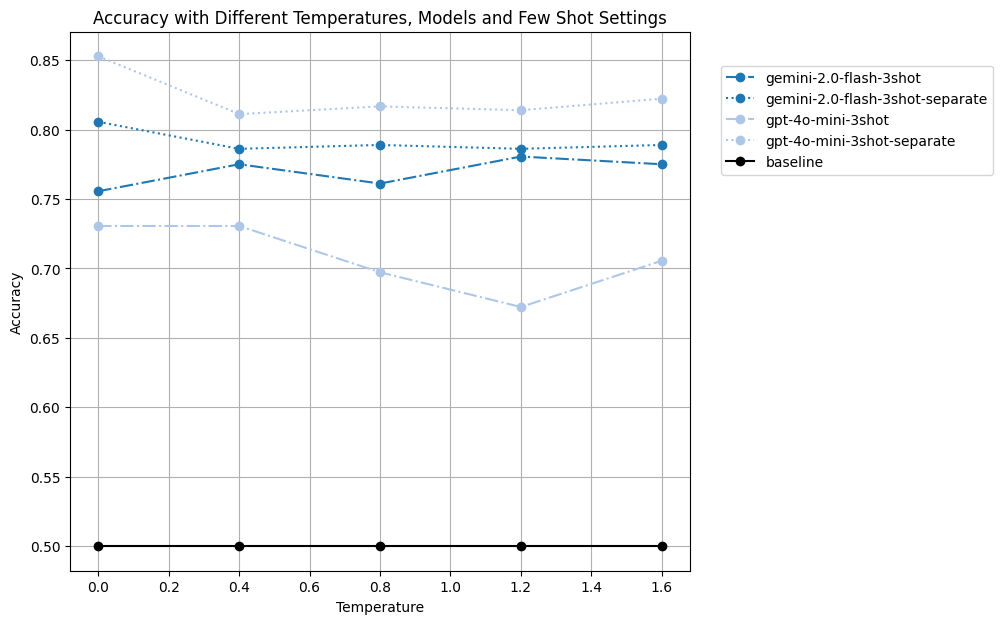

In [60]:
plt.figure(figsize=(8, 7))

linestyles = {
    "0": "solid",
    "1": "dashed",
    "3": "dashdot",
    "3s": "dotted"
}

model_list = df_model_acc_avg['model'].unique()
color_map = {model: plt.cm.tab20(i) for i, model in enumerate(model_list)}

for model in df_model_acc_avg['model'].unique():
    for few_shot in df_model_acc_avg['few shot'].unique():
        subset = df_model_acc_avg[(df_model_acc_avg['model'] == model) & (df_model_acc_avg['few shot'] == few_shot)]

        linestyle = linestyles.get(few_shot, "solid")
        color = color_map[model]
        
        if few_shot != '3s':
            shot_label = f"{few_shot}shot"
        else:
            shot_label = '3shot-separate'
        label = f"{model}-{shot_label}"
        
        plt.plot(subset['temperature'], subset['accuracy'], marker='o', linestyle=linestyle, color=color, label=label)

baseline_y = [0.5] * len(df_model_acc_avg['temperature'].unique())
baseline_x = sorted(df_model_acc_avg['temperature'].unique())

plt.plot(
    baseline_x,
    baseline_y,
    marker='o',
    linestyle="solid",
    color="black",
    label="baseline"
)

plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.title('Accuracy with Different Temperatures, Models and Few Shot Settings')
plt.legend(bbox_to_anchor=(1.5, 0.95), loc='upper right')
plt.grid(True)
plt.show()